/tmp/ipykernel_18459/3023641131.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


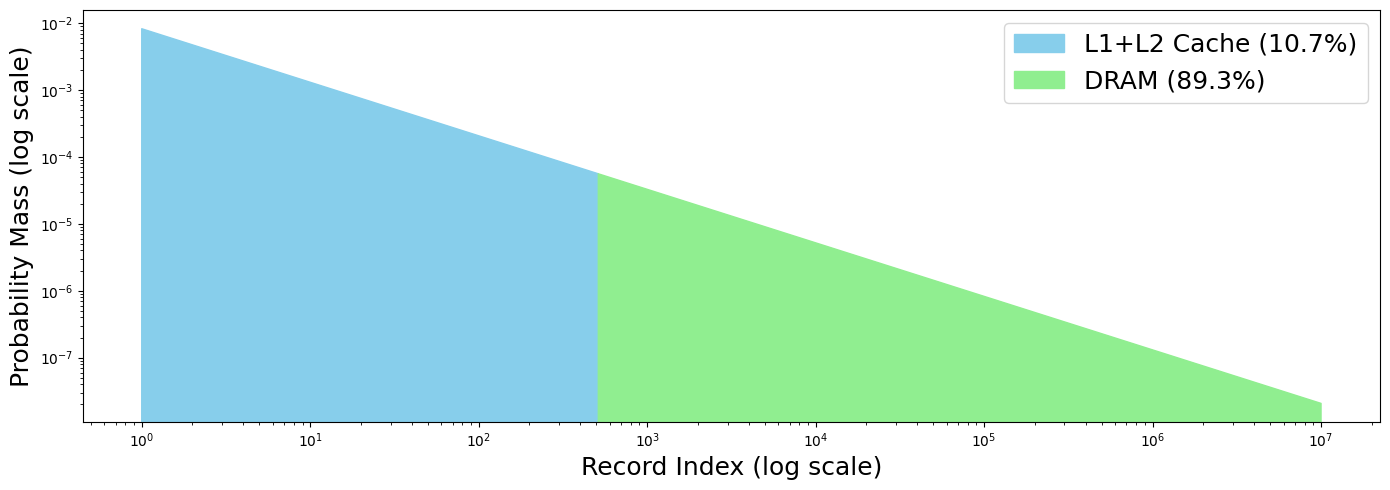

{'L_true_ns': np.float64(89.71762273933793),
 'L_worst_case_ns': np.float64(99.31762273933793),
 'RelErr_worst_case_%': np.float64(10.700238935099152),
 'L_uniform_ns': np.float64(94.51762273933792),
 'RelErr_uniform_%': np.float64(5.350119467549569),
 'L_small_error_ns': np.float64(90.19762273933793),
 'RelErr_small_error_%': np.float64(0.5350119467549617)}

In [6]:
# Re-run everything needed for the plot after the reset
import numpy as np
import matplotlib.pyplot as plt

# Parameters
alpha = 0.8
record_count = int(1e7)
cache_records = 512
dram_records = record_count

# Generate Zipf PMF
k = np.arange(1, record_count + 1)
zipf_pmf = 1 / k**alpha
zipf_pmf /= np.sum(zipf_pmf)

# Recalculate harmonic values for tier probabilities
def generalized_harmonic(n, alpha):
    k = np.arange(1, n + 1)
    return np.sum(1 / k ** alpha)

cache_cumsum = generalized_harmonic(cache_records, alpha)
dram_cumsum = generalized_harmonic(dram_records, alpha)
H_N = dram_cumsum

p_cache = cache_cumsum / H_N
p_dram = (dram_cumsum - cache_cumsum) / H_N

# Plot the PMF with colored tiers
plt.figure(figsize=(14, 5))

# Cache tier
plt.fill_between(k[:cache_records], zipf_pmf[:cache_records], color='skyblue', label=f'L1+L2 Cache ({p_cache*100:.1f}%)')

# DRAM tier
plt.fill_between(k[cache_records:], zipf_pmf[cache_records:], color='lightgreen', label=f'DRAM ({p_dram*100:.1f}%)')

# Plot settings
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Record Index (log scale)", fontsize=18)
plt.ylabel("Probability Mass (log scale)", fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()

lat_cache = 4
lat_dram = 100

# True expected latency
L_true = p_cache * lat_cache + p_dram * lat_dram

# Worst-case TVD=0.1 (entire shift from cache to DRAM)
delta = 0.1
p_cache_wc = p_cache - delta
p_dram_wc = p_dram + delta
L_wc = p_cache_wc * lat_cache + p_dram_wc * lat_dram

# Uniform TVD=0.1 (split evenly between 2 tiers)
delta_uniform = 0.1 / 2
p_cache_u = p_cache - delta_uniform
p_dram_u = p_dram + delta_uniform
L_u = p_cache_u * lat_cache + p_dram_u * lat_dram

# Small uniform TVD=0.01 (well-behaved sampler)
delta_small = 0.01 / 2
p_cache_s = p_cache - delta_small
p_dram_s = p_dram + delta_small
L_s = p_cache_s * lat_cache + p_dram_s * lat_dram

# Relative errors
rel_err_wc = (L_wc - L_true) / L_true * 100
rel_err_u = (L_u - L_true) / L_true * 100
rel_err_s = (L_s - L_true) / L_true * 100

{
    "L_true_ns": L_true,
    "L_worst_case_ns": L_wc,
    "RelErr_worst_case_%": rel_err_wc,
    "L_uniform_ns": L_u,
    "RelErr_uniform_%": rel_err_u,
    "L_small_error_ns": L_s,
    "RelErr_small_error_%": rel_err_s
}


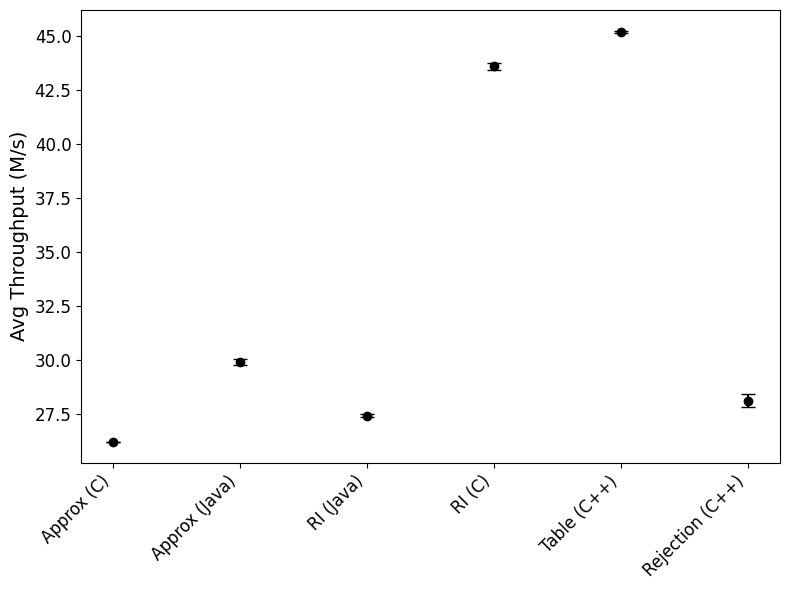

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Recreate the data from the image
data = {
    "Sampler": [
        "Approx (C)",
        "Approx (Java)",
        "RI (Java)",
        "RI (C)",
        "Table (C++)",
        "Rejection (C++)"
    ],
    "Mean": [26.2, 29.9, 27.4, 43.6, 45.2, 28.1],
    "Std": [0.01, 0.14, 0.07, 0.15, 0.06, 0.30]
}

df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
plt.errorbar(df["Sampler"], df["Mean"], yerr=df["Std"], fmt='o', capsize=5, markersize=6, linestyle='none', color='black')
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Avg Throughput (M/s)", fontsize=14)
plt.tight_layout()
plt.show()


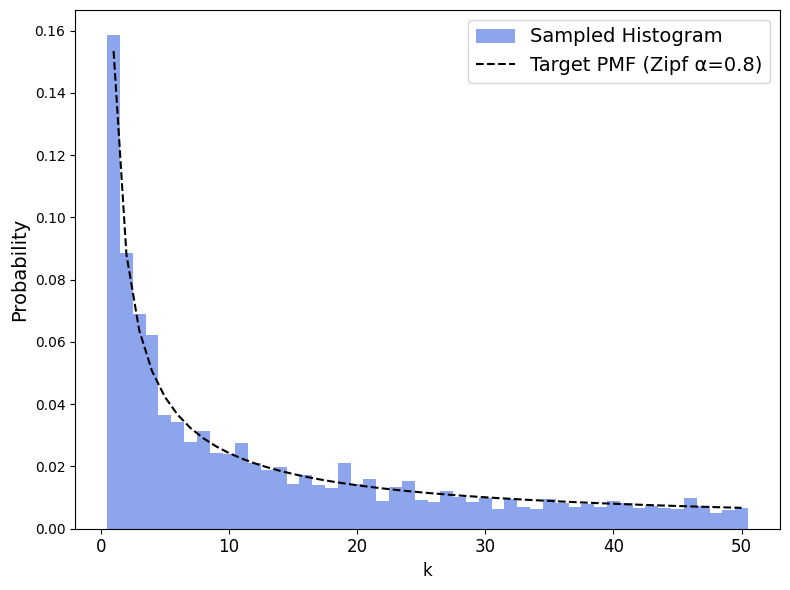

In [18]:
# Python version of Jason Crease's Java-based Zipf rejection sampler

import numpy as np
import matplotlib.pyplot as plt

class ZipfRejectionSampler:
    def __init__(self, N, skew):
        self.N = N
        self.skew = skew
        if skew == 1.0:
            # avoid division by zero
            self.t = np.log(N) + skew
        else:
            self.t = (N**(1 - skew) - skew) / (1 - skew)

    def b_inv_cdf(self, p):
        if p * self.t <= 1:
            return p * self.t
        else:
            return ((p * self.t) * (1 - self.skew) + self.skew) ** (1 / (1 - self.skew))

    def get_sample(self):
        while True:
            invB = self.b_inv_cdf(np.random.rand())
            sampleX = int(invB + 1)
            yRand = np.random.rand()

            ratio_top = sampleX ** (-self.skew)
            ratio_bottom = (1 / self.t) if sampleX <= 1 else (invB ** (-self.skew)) / self.t
            rat = ratio_top / (ratio_bottom * self.t)

            if yRand < rat:
                return sampleX

# Sampling parameters
alpha = 0.8
N = 50
n_samples = 3000

# Create sampler and generate samples
sampler = ZipfRejectionSampler(N=N, skew=alpha)
samples = [sampler.get_sample() for _ in range(n_samples)]

# Compute target PMF
x_vals = np.arange(1, N + 1)
target_pmf = 1 / x_vals**alpha
target_pmf /= np.sum(target_pmf)

# Plot histogram vs target PMF
plt.figure(figsize=(8, 6))
plt.hist(samples, bins=np.arange(1, N+2)-0.5, density=True, alpha=0.6, color='royalblue', label='Sampled Histogram')
plt.plot(x_vals, target_pmf, 'k--', label='Target PMF (Zipf α=0.8)')
plt.xlabel("k", fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel("Probability", fontsize=14)
plt.legend(prop={'size': 14})
plt.tight_layout()
plt.show()

0.261181661921833


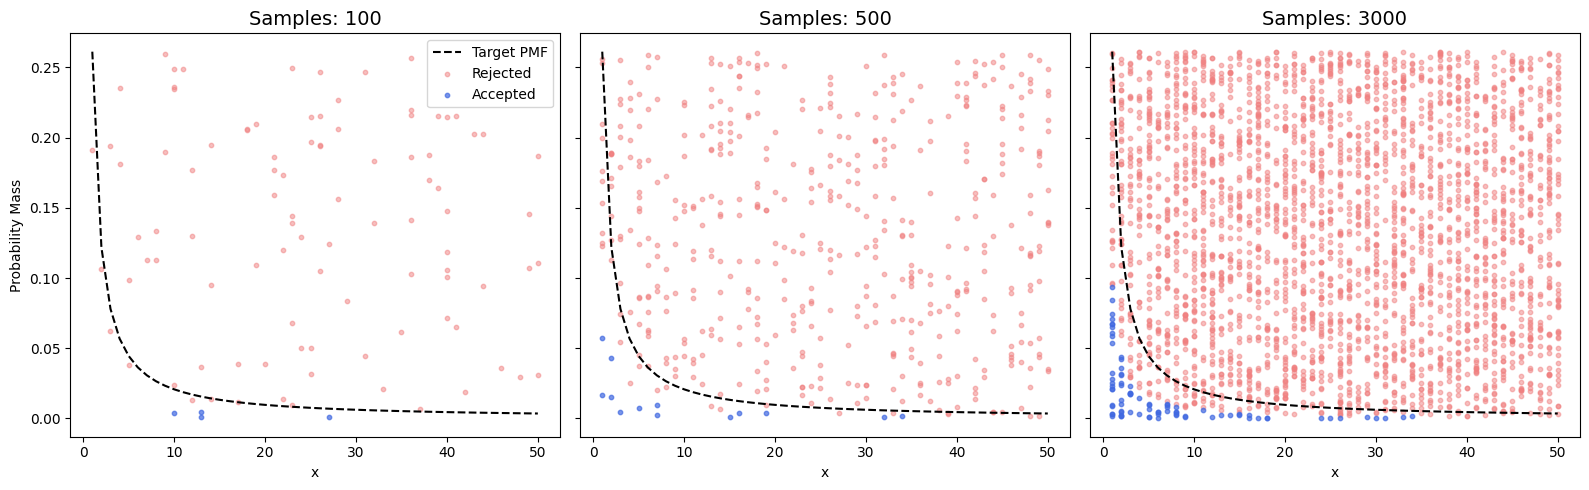

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zipf

# Parameters for the Zipf distribution
a = 1.1  # Zipf parameter
k_max = 50  # max domain value for truncation
samples_list = [100, 500, 3000]

# Define the target PMF for a truncated Zipf distribution
x_vals = np.arange(1, k_max + 1)
pmf_vals = zipf.pmf(x_vals, a)
pmf_vals /= np.sum(pmf_vals)  # normalize (truncate to k_max)
max_pmf = np.max(pmf_vals)
print(max_pmf)

# Proposal distribution: uniform over the same range
proposal_pdf = 1 / k_max

# Create figure
fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for idx, n_samples in enumerate(samples_list):
    accepted_x, rejected_x = [], []
    accepted_y, rejected_y = [], []

    for _ in range(n_samples):
        x_prop = np.random.randint(1, k_max + 1)
        y_prop = np.random.uniform(0, max_pmf)
        f_x = zipf.pmf(x_prop, a)
        if y_prop < f_x:
            accepted_x.append(x_prop)
            accepted_y.append(y_prop)
        else:
            rejected_x.append(x_prop)
            rejected_y.append(y_prop)

    ax = axs[idx]
    ax.plot(x_vals, pmf_vals, 'k--', label='Target PMF')
    ax.scatter(rejected_x, rejected_y, color='lightcoral', s=10, alpha=0.5, label='Rejected')
    ax.scatter(accepted_x, accepted_y, color='royalblue', s=10, alpha=0.7, label='Accepted')
    ax.set_title(f"Samples: {n_samples}", fontsize=14)
    ax.set_xlabel("x")
    if idx == 0:
        ax.set_ylabel("Probability Mass")

axs[0].legend()
plt.tight_layout()
plt.show()
